### 학과: IT미디어공학과
### 학번: 20191035
### 이름 : 장혜림

## Chap 5. 미래에 볼 영화의 평점 예측하기

In [ ]:
# 필요한 라이브러리들을 임포트한다.
from google.colab import files
import io

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### <Step1. 탐색> : MovieLens 데이터 살펴보기

[1.1] MovieLens 데이터셋 업로드하기

In [ ]:
# Data Source : https://grouplens.org/datasets/movielens
# rating 데이터를 업로드하여 데이터프레임을 생성한다.
rating_file_path = files.upload()

rating_data = pd.read_csv(io.BytesIO(rating_file_path['ratings.dat']),
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')

Saving ratings.dat to ratings.dat


In [ ]:
# moive 데이터를 업로드하여 데이터프레임을 생성한다.
movie_file_path = files.upload()

movie_data = pd.read_csv(io.BytesIO(movie_file_path['movies.dat']), 
                                    names=['movie_id', 'title', 'genre'], delimiter='::', 
                                    encoding="ISO-8859-1")

Saving movies.dat to movies.dat


In [ ]:
# user 데이터를 업로드하여 데이터프레임을 생성한다.
user_file_path = files.upload()

user_data = pd.read_csv(io.BytesIO(user_file_path['users.dat']), 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

Saving users.dat to users.dat


[1.2] MovieLens 데이터셋 기본정보 확인하기

In [ ]:
# rating 데이터의 기본정보를 출력한다.
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
 3   time      1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
# rating 데이터 상위 5건 출력한다.
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
# movie 데이터의 기본정보를 출력한다.
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [ ]:
# movie 데이터 상위 5건 출력한다.
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# user 데이터의 기본정보를 출력한다.
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [ ]:
# user 데이터 상위 5건 출력한다.
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
# 결측 데이터가 있는지 확인한다.
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


-----

### <Step2. 분석> : 탐색적 데이터 분석

[2.1] 분석할 영화의 정보 탐색하기

In [ ]:
## 총 영화의 개수를 출력하시오.
print("total number of movie in data :", rating_data['movie_id'].nunique())

# 연도별 영화 개수가 많은 Top 10 년도를 출력한다.
# 람다함수를 이용해서 영화제목 뒤에 따라붙는 연도정보를 추출한다.

## 람다함수를 이용해서 영화제목(Toy Story (1995)) 뒤에 따라붙는 연도정보를 추출하시오.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])

## 연도별 영화 개수가 많은 Top 10 년도를 출력하시오.
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

[2.2] 장르의 속성 탐색

In [ ]:
# 가장 많이 사용된 장르의 조합을 출력한다. (Top 10)
# value_counts()는 값별 개수에서 개수를 기준으로 내림차순 출력한다.

## 가장 많이 사용된 장르의 조합 Top 10을 출력하시오.
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

In [ ]:
## 가장 많이 등장한 장르의 속성을 추출하시오.

unique_genre_dict = {}   # 빈 딕셔너리를 생성한다.

# iterrows()는 인덱스와 row 데이터를 반복적으로 반환한다.
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리한다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장한다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


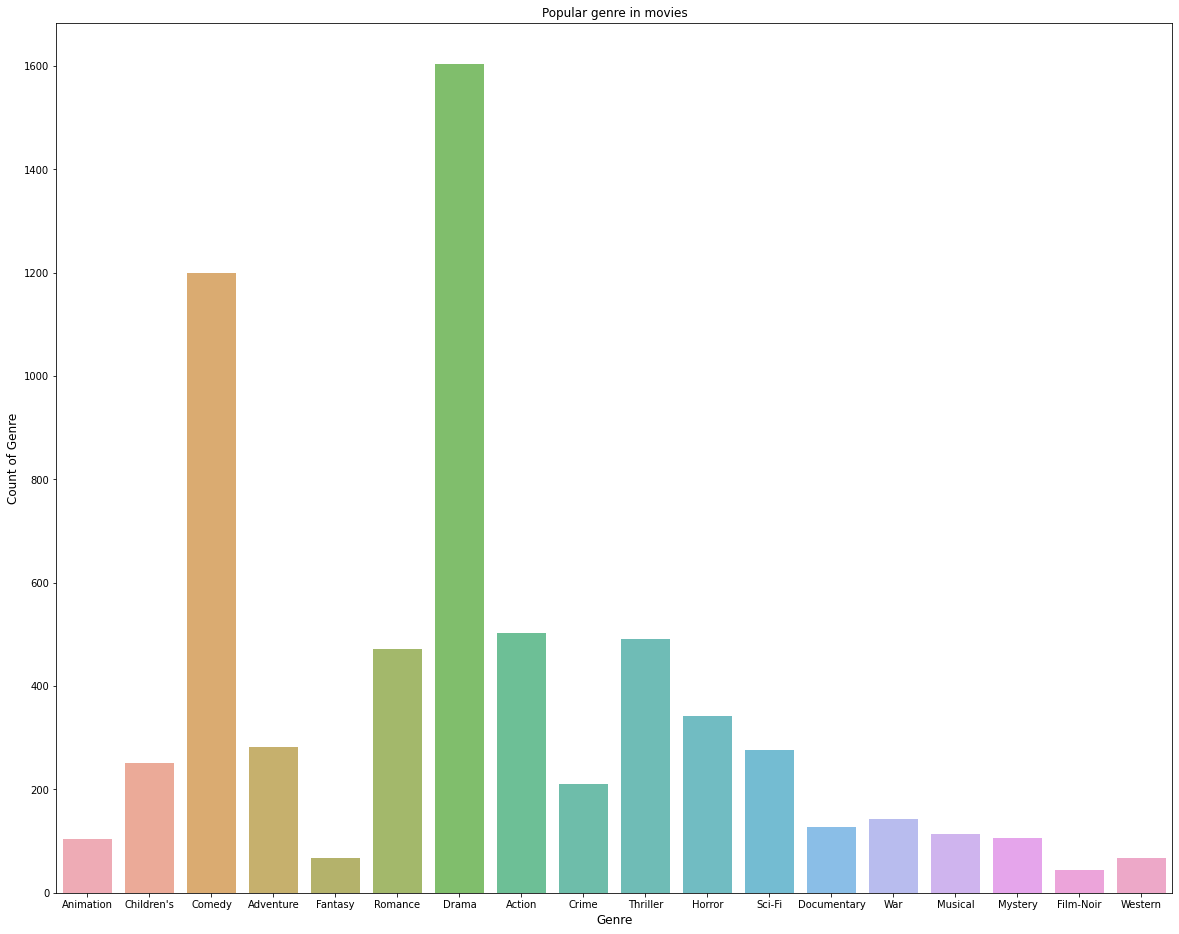

In [ ]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력한다.
plt.rcParams['figure.figsize'] = [20, 16]


## x축은 key 리스트, y축은 value 리스트로 막대그래프를 그리시오.
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)

plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

[2.3] 분석할 유저의 정보 탐색하기

In [ ]:
# 유저의 수를 탐색한다.
# 유저('user_id')의 unique한 값의 개수를 구한다.
print("total number of user in data :", len(user_data['user_id'].unique()))

print("total number of user in data :", user_data['user_id'].nunique())

total number of user in data : 6040
total number of user in data : 6040


-----

[2.4] 평점 데이터의 정보 탐색하기

movie_id
1     2077
2      701
3      478
4      170
5      296
6      940
7      458
8       68
9      102
10     888
Name: rating, dtype: int64


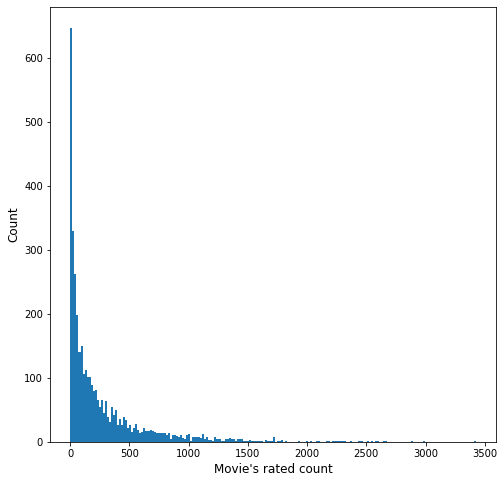

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [ ]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
# 영화('movie_id')별 'rating'를 카운트한다.

## 영화('movie_id')별 평가('rating')받은 횟수를 탐색하시오.
movie_rate_count =  rating_data.groupby('movie_id')['rating'].count()
print(movie_rate_count[:10])

plt.rcParams['figure.figsize'] = [8, 8]

# 영화별 평가받은 횟수를 히스토그램으로 그린다.
fig = plt.hist(movie_rate_count, bins=200)

plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()


[2.5] user-movie 형태의 테이블로 살펴보기

In [ ]:
# [기초] 딕셔너리{key:Value} 데이터를 데이터 프레임으로 생성한다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [ ]:
# [기초] 데이터 프레임을 행렬로 변환(재구조화)하여 확인한다.
# unstack()를 이용하여 재구조화한다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack()

df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          NaN  5.0  NaN

In [ ]:
# [기초] 빈 데이터를 0으로 채워서 코드를 완성한다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)

df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

In [ ]:
# unstack() 함수로 user_id, movie_id를 행, 열 인덱스로 데이터를 재구조화한다.

## user_id, movie_id를 행, 열 인덱스로 지정하고 데이터를 재구조화하시오.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                           ...                              
movie_id   1    2    3    4    5    6     ... 3947 3948 3949 3950 3951 3952
user_id                                   ...                              
1           5.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
2           NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
3           NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
4           NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
5           NaN  NaN  NaN  NaN  NaN  2.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
6           4.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
7           NaN  NaN  NaN  NaN  NaN  4.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
8           4.0  NaN  NaN  3.0  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN
9           5.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  3.0  NaN  NaN  NaN  NaN
10          5.0  5.0  NaN  NaN  NaN  NaN  ...  NaN  4.0  NaN  NaN  NaN  NaN

[10 rows x 3706 columns]

-----

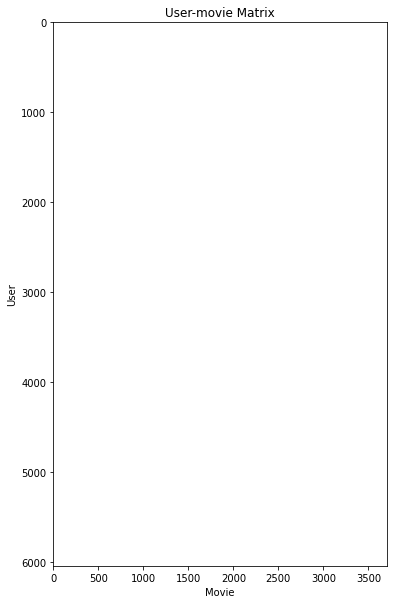

In [ ]:
# user-movie 테이블을 시각화한다.
plt.rcParams['figure.figsize'] = [10, 10]

# imshow()는 행렬의 값을 이미지로 출력한다.

## rating_table 행렬의 값을 이미지로 출력하시오.
plt.imshow(rating_table)

# 격자표시를 보이지않게 한다.
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

-----

### <Step3. 예측> : 수학적 기법을 활용한 평점 예측

[3.1] MovieLens 데이터에 SVD 적용하기

In [ ]:
# SVD를 사용하기 위해 surprise 라이브러리를 설치한다.
!pip install surprise

In [ ]:
# surprise 라이브러리를 임포트한다.
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# 지수표현과 같은 scientific notation을 제거한다.
np.set_printoptions(suppress=True)

[3.1.1] 훈련 데이터셋을 생성하기

In [ ]:
# 행렬 완성 모델(SVD) 사용을 위한 데이터셋을 생성한다.
# load_from_df()와 build_full_trainset() 함수를 이용하여 rating 데이터를 
# surprise 라이브러리의 데이터셋 형태로 변환한다.

## 평점의 범위가 1~5인 Reader 객체를 생성하시오.
reader = Reader(rating_scale=(1, 5))

## reader 객체를 이용하여 df 데이터프레임에서 데이터를 로드해서 데이터셋을 만드시오.
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)

# 훈련세트를 구축한다.
train_data = data.build_full_trainset()

[3.1.2] SVD 모델을 생성하고 학습하기

In [ ]:
# 학습시간을 측정하기위해 현재 시간을 저장한다.
train_start = time.time()

# 행렬 완성 모델(SVD) 객체를 생성한다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)

# 행렬 완성 모델(SVD)을 훈련세트로 학습시킨다.

##  행렬 완성 모델(SVD)을 훈련세트로 학습시키시오.
model.fit(train_data)

train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 0.00 seconds


[3.2] 영화의 점수를 예측할 타겟 유저 선정

In [ ]:
# user_id가 4인 유저의 영화 평가 데이터이다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [ ]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출한다.
target_user_movie_rating_dict = {}

## target_user_data 데이터프레임에서 인덱스와 행을 반환하시오.
for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


-----

[3.3] 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [ ]:
## 타겟 유저가 보지 않은 영화 정보를 테스트 데이터로 생성하시오(전체코드)
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [ ]:
## 타겟 유저의 평점 점수를 예측하시오.
target_user_predictions = model.test(test_data)

## 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장하시오.(전체코드)
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
       if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# 함수를 호출한다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [ ]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정한다.
# items()은 딕셔너리에서 (key, value) 쌍을 반환한다.
# key=operator.itemgetter(1)에서 key는 정렬키를 의미하고 itemgetter(0)은 key, itemgetter(1)은 value.
# sorted()는 오름차순이 기본이고 reverse=True을 주면 내림차순이 된다.

## target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정하시오.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [ ]:
# 예측된 Top 10 영화(평점이 높은 영화)를 출력한다.
target_user_top10_predicted

[(106, 5),
 (213, 5),
 (309, 5),
 (326, 5),
 (527, 5),
 (602, 5),
 (615, 5),
 (632, 5),
 (670, 5),
 (750, 5)]

In [ ]:
## 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장하시오.(전체코드)
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [ ]:
## 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력하시오.(전체코드)
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Lamerica (1994) : 5
Taxi Driver (1976) : 5
Before the Rain (Pred dozhdot) (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Godfather, The (1972) : 5


In [ ]:
## 타겟 유저의 기존 선호 영화와 비교하시오.(전체코드)
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5
